In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import pickle
from datetime import datetime

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [43]:
df_student_original = pd.read_excel('./dataset/NeptunExport_merged.xlsx')

In [44]:
df_student = df_student_original.copy()

In [6]:
# Drop old system
drop_old_system_students = df_student.loc[df_student['AdmissionSemester']<='2008-01-01'].index
df_student.drop(index=drop_old_system_students, inplace=True)

# Drop finished students
df_student.drop(index=df_student[df_student['StatusId']=='Diplomát szerzett'].index, inplace=True)

# Drop unnecessary cols
df_student.drop(columns=['ModuleCode','LegalRelationshipTerminationReason','EnrollmentType','Prerequisites','Recognized','EntryType','Program','DiplomaObtainingDate','AdmissionFinancialStatus'],inplace=True)

In [7]:
# Drop Aláírva
df_student = df_student[df_student['EntryValue']!='Aláírva']

In [8]:
# Only list valid results
df_student = df_student[df_student['Valid']=='Igaz']

In [9]:
# mappings
grades = {'Jeles':5,
          'Elégtelen':1,
          'Megtagadva':-1,
          'Jó':4,
          'Elégséges':2,
          'Közepes':3,
          'teljesítettnek tekintendő':0,
          'Kiválóan megfelelt (5)':5,
          'Jól megfelelt':4}

df_student['EntryValue'] = df_student['EntryValue'].map(grades)

map_status = {'Aktív':0,
              'Törölt':1,
              'Passzív':0,
              'Abszolvált':0,
              'Sikertelen záróvizsga':0,
              'Diplomát szerzett':0}

df_student['StatusId'] = df_student['StatusId'].map(map_status)

map_subject_completed = {'Igaz':1,
                         'Hamis':0}

df_student['Completed'] = df_student['Completed'].map(map_subject_completed)

In [10]:
# Language exam var.
df_student['language_exam_available'] = df_student['LanguageExamFulfillmentDate'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [11]:
# Only the first admission is considered
df_min_admission = df_student.groupby(by='NeptunCode').min()['AdmissionSemester'].reset_index()
df_student = df_student.join(df_min_admission.rename(columns={'AdmissionSemester':'AdmissionSemester_min'}).set_index('NeptunCode'), on='NeptunCode')
df_student['AdmissionSemester'] = df_student[['AdmissionSemester','AdmissionSemester_min']].apply(lambda x: x[1] if x[0]!=x[1] else x[0], axis=1)

In [12]:
# Ujrafelvetelizett hallgato --> Ne fogadjuk el a targyakat
df_student_temp = df_student.loc[df_student['Completed']==1]
df_subject_completed_min_date = df_student_temp.groupby(by=['NeptunCode','SubjectCode']).min()['Semester'].reset_index()
df_student = pd.merge(df_student, df_subject_completed_min_date, on=['NeptunCode','SubjectCode'], suffixes=['_original','_min'], how='left')
df_student['Semester_min'].fillna(df_student['Semester_original'], inplace=True)
df_student = df_student.loc[df_student['Semester_min']>=df_student['Semester_original']]

In [13]:

def calculate_semester_difference(sem1, sem2):
    """Calculate the difference in semesters between two strings"""
    # Extract the academic year and semester from the input strings
    sem1_parts = sem1.split('/')
    sem2_parts = sem2.split('/')
    year1 = sem1_parts[0] + '/' + sem1_parts[1]
    year2 = sem2_parts[0] + '/' + sem2_parts[1]
    sem_num1 = int(sem1_parts[-1])
    sem_num2 = int(sem2_parts[-1])
    
    # Convert the academic year strings to datetime objects
    year1_start = datetime.strptime(year1+'/1/1', '%Y/%y/%m/%d')
    year2_start = datetime.strptime(year2+'/1/1', '%Y/%y/%m/%d')
    
    # Calculate the difference in years and semesters between the two academic years
    years = year2_start.year - year1_start.year
    semesters = (year2_start.month - year1_start.month) // 6
    
    # Calculate the total difference in semesters
    difference = years * 2 + semesters + sem_num2 - sem_num1
    
    return difference

In [14]:
df_student['t'] = df_student[['AdmissionSemester','Semester_original']].apply(lambda x: calculate_semester_difference(x[0],x[1]),axis=1)
df_student['t'] = df_student['t']+1 

In [15]:
groups = df_student.groupby('NeptunCode')
# Create a dictionary that maps each original rank to its new value for each group
new_ranks = {}
for name, group in groups:
    for i, rank in enumerate(sorted(set(group['t']))):
        new_ranks[(name, rank)] = i + 1

# Update the rank column of the dataframe using the new_ranks dictionary
df_student['t_new'] = df_student.apply(lambda row: new_ranks[(row['NeptunCode'], row['t'])], axis=1)

In [16]:
df_student['rn'] = df_student.sort_values(['Semester_original'], ascending=[False]) \
                                    .groupby(['NeptunCode']) \
                                    .cumcount() + 1


In [17]:
df_model = df_student.loc[df_student['rn']==1,['NeptunCode','t_new','StatusId','AdmissionScoreTotal','language_exam_available']]

In [18]:
df_model.head()

,NeptunCode,t_new,StatusId,AdmissionScoreTotal,language_exam_available
16,NK-12,3,1,289.0,0
39,NK-448,3,1,331.0,0
90,NK-114,6,1,NaN,0
93,NK-76,1,1,347.0,0
145,NK-129,1,1,364.0,0


In [19]:
df_avg_credit_in_semester_temp = df_student[['NeptunCode','t_new','EnrollmentCredit']].groupby(by=['NeptunCode','t_new']).sum().reset_index()
df_avg_credit_in_semester = df_avg_credit_in_semester_temp.groupby(by='NeptunCode').mean()['EnrollmentCredit'].reset_index()

In [20]:
df_subjects_mean = df_student[['NeptunCode','Completed','SubjectTakenCount']].groupby(by='NeptunCode').mean().reset_index()

In [323]:
df_student[df_student['NeptunCode']=='NK-47']

,NeptunCode,AdmissionSemester,LegalRelationshipEstablishmentReason,LegalRelationshipStartDate,StatusId,LegalRelationshipEndDate,Semester_original,SubjectCode,SubjectName,Completed,EnrollmentCredit,SubjectTakenCount,EntryValue,Valid,AdmissionScoreTotal,LanguageExamFulfillmentDate,language_exam_available,AdmissionSemester_min,Semester_min,t,t_new,rn
5604,NK-47,2019/20/1,Felvétel,2019-09-02,1,2019-10-28,2019/20/1,VEMKLE12X0A,Angol nyelvi kollokviumi vizsga,1,0,1,5,Igaz,318.0,NaT,0,2019/20/1,2019/20/1,1,1,1
5605,NK-47,2019/20/1,Felvétel,2019-09-02,1,2019-10-28,2019/20/1,VEMKLE22X0A,Angol nyelvi záróvizsga,1,0,1,5,Igaz,318.0,NaT,0,2019/20/1,2019/20/1,1,1,2


In [324]:
df_student_original[df_student_original['NeptunCode']=='NK-240']

,NeptunCode,ModuleCode,AdmissionSemester,LegalRelationshipEstablishmentReason,LegalRelationshipStartDate,StatusId,LegalRelationshipEndDate,LegalRelationshipTerminationReason,Semester,SubjectCode,SubjectName,Completed,EnrollmentType,EnrollmentCredit,SubjectTakenCount,Prerequisites,Recognized,EntryValue,EntryType,Valid,Program,DiplomaObtainingDate,AdmissionScoreTotal,AdmissionFinancialStatus,LanguageExamFulfillmentDate
50672,NK-240,MI-PR-B02,2019/20/1,Felvétel,2019-09-02,Törölt,2019-12-10,Saját bejelentés a képzés megszakítására,2019/20/1,VEMIMAB143A,Az informatika logikai és algebrai alapjai,Hamis,Kötelező,3,1,Vizsga,Hamis,Megtagadva,Aláírás,Hamis,Nappali,NaT,344.0,Állami ösztöndíjas,NaT
50673,NK-240,MI-PR-B02,2019/20/1,Felvétel,2019-09-02,Törölt,2019-12-10,Saját bejelentés a képzés megszakítására,2019/20/1,VEMIMAB144A,Matematikai analízis I.,Hamis,Kötelező,4,1,Vizsga,Hamis,Megtagadva,Aláírás,Hamis,Nappali,NaT,344.0,Állami ösztöndíjas,NaT
50674,NK-240,MI-PR-B02,2019/20/1,Felvétel,2019-09-02,Törölt,2019-12-10,Saját bejelentés a képzés megszakítására,2019/20/1,VEMIVIB112A,A számítástechnika alapjai,Hamis,Kötelező,2,1,Folyamatos számonkérés,Hamis,Megtagadva,Aláírás,Hamis,Nappali,NaT,344.0,Állami ösztöndíjas,NaT
50675,NK-240,MI-PR-B02,2019/20/1,Felvétel,2019-09-02,Törölt,2019-12-10,Saját bejelentés a képzés megszakítására,2019/20/1,VEMKLE12X0A,Angol nyelvi kollokviumi vizsga,Igaz,Kötelező,0,1,Kollokvium,Igaz,Jeles,Kollokvium,Igaz,Nappali,NaT,344.0,Állami ösztöndíjas,NaT
50676,NK-240,MI-PR-B02,2019/20/1,Felvétel,2019-09-02,Törölt,2019-12-10,Saját bejelentés a képzés megszakítására,2019/20/1,VEMKLE12X0A,Angol nyelvi kollokviumi vizsga,Igaz,Kötelező,0,1,Kollokvium,Igaz,Aláírva,Aláírás,Hamis,Nappali,NaT,344.0,Állami ösztöndíjas,NaT
50677,NK-240,MI-PR-B02,2019/20/1,Felvétel,2019-09-02,Törölt,2019-12-10,Saját bejelentés a képzés megszakítására,2019/20/1,VEMKLE22X0A,Angol nyelvi záróvizsga,Igaz,Kötelező,0,1,Kollokvium,Igaz,Aláírva,Aláírás,Hamis,Nappali,NaT,344.0,Állami ösztöndíjas,NaT
50678,NK-240,MI-PR-B02,2019/20/1,Felvétel,2019-09-02,Törölt,2019-12-10,Saját bejelentés a képzés megszakítására,2019/20/1,VEMKLE22X0A,Angol nyelvi záróvizsga,Igaz,Kötelező,0,1,Kollokvium,Igaz,Jeles,Kollokvium,Igaz,Nappali,NaT,344.0,Állami ösztöndíjas,NaT


In [325]:
#df_student = df_student[df_student['NeptunCode']!='NK-47']
#df_student = df_student[df_student['NeptunCode']!='NK-240']

In [22]:
def calculate_weighted(x):
    try:
        return np.average(x, weights=df_weighted_avg_temp.loc[x.index, 'EnrollmentCredit'])
    except:
        return np.nan

In [23]:
df_weighted_avg_temp = df_student[df_student['EntryValue']!=-1]

In [24]:
weighted_avg = df_weighted_avg_temp.groupby('NeptunCode')['EntryValue'].apply(calculate_weighted)
#weighted_avg = df_weighted_avg_temp.groupby('NeptunCode')['EntryValue'].apply(lambda x: np.average(x, weights=df_weighted_avg_temp.loc[x.index, 'EnrollmentCredit']))
weighted_avg = weighted_avg.reset_index()

In [27]:
df_model = df_model.join(df_avg_credit_in_semester.set_index('NeptunCode'), on='NeptunCode', how='left')
df_model = df_model.join(df_subjects_mean.set_index('NeptunCode'), on='NeptunCode', how='left')
df_model = df_model.join(weighted_avg.set_index('NeptunCode'), on='NeptunCode', how='left')

In [28]:
df_model.describe()

,t_new,StatusId,AdmissionScoreTotal,language_exam_available,EnrollmentCredit,Completed,SubjectTakenCount,EntryValue
count,528.000000,528.000000,520.000000,528.000000,528.000000,528.000000,528.000000,513.000000
mean,3.721591,0.492424,353.642308,0.032197,20.930390,0.719245,1.122198,2.882195
std,2.841170,0.500417,47.022961,0.176690,12.108700,0.263614,0.160271,0.877452
min,1.000000,0.000000,244.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,317.000000,0.000000,15.000000,0.600000,1.000000,2.333333
50%,3.000000,0.000000,346.000000,0.000000,21.000000,0.780193,1.062500,2.890411
75%,5.000000,1.000000,384.000000,0.000000,27.471429,0.916667,1.195522,3.456790
max,18.000000,1.000000,494.000000,1.000000,130.000000,1.000000,1.800000,5.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x2ce1ce65c70>,
 'caps': [<matplotlib.lines.Line2D at 0x2ce1ce6d1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2ce1ce659d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2ce1ce6d730>],
 'fliers': [<matplotlib.lines.Line2D at 0x2ce1ce6d9d0>],
 'means': []}

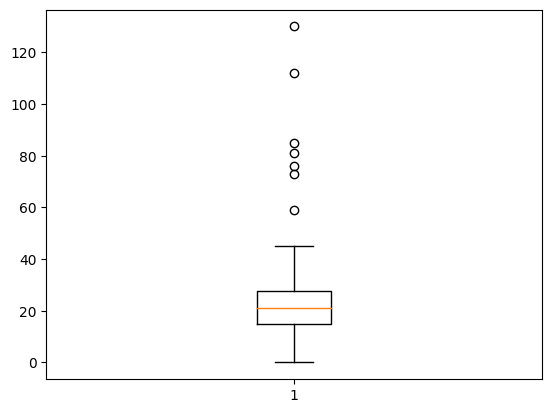

In [29]:
plt.boxplot(df_model['EnrollmentCredit'])

In [30]:
df_model = df_model[df_model['EnrollmentCredit']<=50]

In [31]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521 entries, 16 to 14050
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NeptunCode               521 non-null    object 
 1   t_new                    521 non-null    int64  
 2   StatusId                 521 non-null    int64  
 3   AdmissionScoreTotal      515 non-null    float64
 4   language_exam_available  521 non-null    int64  
 5   EnrollmentCredit         521 non-null    float64
 6   Completed                521 non-null    float64
 7   SubjectTakenCount        521 non-null    float64
 8   EntryValue               506 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 40.7+ KB


In [32]:
df_model[df_model['EntryValue'].isnull()]

,NeptunCode,t_new,StatusId,AdmissionScoreTotal,language_exam_available,EnrollmentCredit,Completed,SubjectTakenCount,EntryValue
154,NK-142,1,1,384.0,0,0.0,0.0,1.0,NaN
219,NK-745,1,1,308.0,0,0.0,0.0,1.0,NaN
563,NK-23,1,1,298.0,1,0.0,0.0,1.0,NaN
755,NK-254,1,1,322.0,1,0.0,0.0,1.0,NaN
784,NK-325,1,1,301.0,0,0.0,0.0,1.0,NaN
2529,NK-473,1,1,300.0,0,0.0,0.0,1.0,NaN
4200,NK-134,1,1,425.0,0,0.0,0.0,1.0,NaN
4904,NK-497,1,1,344.0,0,0.0,0.0,1.0,NaN
5604,NK-47,1,1,318.0,0,0.0,1.0,1.0,NaN
6553,NK-240,1,1,344.0,0,0.0,1.0,1.0,NaN


In [33]:
df_model = df_model[~df_model['EntryValue'].isnull()]

In [34]:
imputer = KNNImputer(n_neighbors=10)
df_model[['AdmissionScoreTotal','EnrollmentCredit','Completed','SubjectTakenCount','EntryValue']] = imputer.fit_transform(df_model[['AdmissionScoreTotal','EnrollmentCredit','Completed','SubjectTakenCount','EntryValue']])

In [36]:
filename_1 = './artifacts/knn_imputer.pkl'
pickle.dump(imputer, open(filename_1, 'wb'))

In [37]:
df_model.describe()

,t_new,StatusId,AdmissionScoreTotal,language_exam_available,EnrollmentCredit,Completed,SubjectTakenCount,EntryValue
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.839921,0.478261,354.459091,0.029644,20.623016,0.733346,1.126704,2.873372
std,2.843799,0.500022,47.077608,0.169772,8.390672,0.240626,0.161815,0.878838
min,1.000000,0.000000,244.000000,0.000000,1.500000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,318.000000,0.000000,15.350000,0.610368,1.000000,2.311126
50%,3.000000,0.000000,347.500000,0.000000,21.250000,0.783461,1.066667,2.878442
75%,5.000000,1.000000,388.750000,0.000000,27.383333,0.915164,1.200000,3.448005
max,18.000000,1.000000,494.000000,1.000000,45.000000,1.000000,1.800000,5.000000


In [38]:
df_model['StatusId'] = df_model['StatusId'].astype(bool)
df_model = df_model[df_model['t_new']<=12]

In [39]:
# Save df
filename = './artifacts/df_model.pkl'
pickle.dump(df_model, open(filename, 'wb'))